<a href="https://colab.research.google.com/github/ezeiberg33/spinSynthFinal/blob/main/originalPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training the pix2pix model using the unharmonized data.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install monai nibabel numpy scipy matplotlib tqdm SimpleITK
!pip install neuroHarmonize nilearn tqdm
!pip install neuroHarmonize neuroCombat

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 80.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neuroCombat: filename=neuroCombat-0.2.12-py3-none-any.whl size=6353 sha256=4ac3a81019c90421b6a6e4f0d014c2f2ac8184bc83d3fc40b270d624b33d2bf8
  Stored in directory: /root/.cache/pip/wheels/be/6a/95/9d827c0f3cc23854b5fbd00fbc8a052d492538dc16bd20f7a2
Successfully built neuroCombat


In [ ]:
import torch
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from nilearn import datasets, image, masking
from tqdm import tqdm
from neuroHarmonize import harmonizationLearn
import seaborn as sns
import imageio
import tensorflow as tf
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create train and test datasets

All data comes from HH and Guys locations, IOP location is excluded since images from here had a distinct style.

89 training images from each location.
23 testing images from each location.

1 slice is extracted from each .nii.gz file and saved as a .png file. The files are save in the form:
"scan type" _ "location" _ "patient id".png




In [ ]:
rng = np.random.default_rng()
t1_dir = "/content/drive/MyDrive/finalT1T2Data/Registered/T1"
t2_dir = "/content/drive/MyDrive/finalT1T2Data/Registered/T2"


t1_files = sorted([f for f in os.listdir(t1_dir) if f.endswith(('.nii', '.nii.gz'))])
t1_full_names=[]
for f in t1_files:
  f_full_name = os.path.join(t1_dir, f)
  t1_full_names.append(f_full_name)

t2_files = sorted([f for f in os.listdir(t2_dir) if f.endswith(('.nii', '.nii.gz'))])
t2_full_names=[]
for f in t2_files:
  f_full_name = os.path.join(t2_dir, f)
  t2_full_names.append(f_full_name)

meta_path = "IXI.xls"
meta_data = pd.read_excel(meta_path)

FileNotFoundError: [Errno 2] No such file or directory: 'IXI.xls'

In [ ]:
ids = [int(f.split('-')[0][-3:]) for f in t1_full_names and t2_full_names]
used_patiets_meta = meta_data.loc[meta_data['IXI_ID'].isin(ids)]
used_patiets_meta=used_patiets_meta.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=False, ignore_index=False)
t1_full_names_keep = []
t2_full_names_keep = []
ids_keep = []
for i in ids:
  if i in used_patiets_meta["IXI_ID"].values:
    ids_keep.append(i)

for f in t1_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t1_full_names_keep.append(f)

for f in t2_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t2_full_names_keep.append(f)
locations = [f.split('-')[1] for f in t1_full_names_keep]
used_patiets_meta['SITE'] = locations

In [ ]:
guys_indices = [i for i, item in enumerate(locations) if 'Guys' in item]#[:200]
HH_indices = [i for i, item in enumerate(locations) if 'HH' in item]#[:100]
representative_indices = guys_indices + HH_indices
representative_indices.sort()

In [ ]:
guys_indices_train = guys_indices[:int(len(HH_indices)*0.8)]
HH_indices_train = HH_indices[:int(len(HH_indices)*0.8)]
guys_indices_test = guys_indices[int(len(HH_indices)*0.8):len(HH_indices)]
HH_indices_test = HH_indices[int(len(HH_indices)*0.8):]

In [ ]:
train_indices = guys_indices_train + HH_indices_train
train_indices.sort()

test_indices = guys_indices_test + HH_indices_test
test_indices.sort()

In [ ]:
t1_rep_full_names_train=[]
t2_rep_full_names_train=[]
for i in train_indices:
  t1_rep_full_names_train.append(t1_full_names_keep[i])
  t2_rep_full_names_train.append(t2_full_names_keep[i])

In [ ]:
t1_rep_full_names_test=[]
t2_rep_full_names_test=[]
for i in test_indices:
  t1_rep_full_names_test.append(t1_full_names_keep[i])
  t2_rep_full_names_test.append(t2_full_names_keep[i])

In [ ]:
t1_rep_full_names_train[1]

'/content/drive/MyDrive/T1T2Data/Registered/T1/IXI012-HH-1211-T1.nii.gz'

In [ ]:
# Training data
output_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc/"

os.makedirs(output_dir + "T1", exist_ok=True)
os.makedirs(output_dir + "T2", exist_ok=True)

for patient in range(len(t1_rep_full_names_train)):
    print(patient)
    pid = int(t1_rep_full_names_train[patient].split('-')[2])
    loc = t1_rep_full_names_train[patient].split('-')[1]
    t1 = nib.load(t1_rep_full_names_train[patient]).get_fdata()
    t2 = nib.load(t2_rep_full_names_train[patient]).get_fdata()

    # choose mid-slice
    z = t1.shape[0] // 2
    t1_slice = t1[z, :, :]
    t2_slice = t2[z, :, :]

    # normalize
    t1_slice = (t1_slice - t1_slice.min()) / (t1_slice.max() - t1_slice.min())
    t2_slice = (t2_slice - t2_slice.min()) / (t2_slice.max() - t2_slice.min())

    # save as PNG
    imageio.imwrite(output_dir + f"T1/T1_{loc}_{pid}.png", (t1_slice * 255).astype(np.uint8))
    imageio.imwrite(output_dir + f"T2/T2_{loc}_{pid}.png", (t2_slice * 255).astype(np.uint8))


In [ ]:
# Testing data
output_dir = "/content/drive/MyDrive/finalT1T2Data/test_w_loc/"

os.makedirs(output_dir + "T1", exist_ok=True)
os.makedirs(output_dir + "T2", exist_ok=True)

for patient in range(len(t1_rep_full_names_test)):
    print(patient)
    pid = int(t1_rep_full_names_test[patient].split('-')[2])
    loc = t1_rep_full_names_test[patient].split('-')[1]
    t1 = nib.load(t1_rep_full_names_test[patient]).get_fdata()
    t2 = nib.load(t2_rep_full_names_test[patient]).get_fdata()

    # choose mid-slice
    z = t1.shape[0] // 2
    t1_slice = t1[z, :, :]
    t2_slice = t2[z, :, :]

    # normalize
    t1_slice = (t1_slice - t1_slice.min()) / (t1_slice.max() - t1_slice.min())
    t2_slice = (t2_slice - t2_slice.min()) / (t2_slice.max() - t2_slice.min())

    # save as PNG
    imageio.imwrite(output_dir + f"T1/T1_{loc}_{pid}.png", (t1_slice * 255).astype(np.uint8))
    imageio.imwrite(output_dir + f"T2/T2_{loc}_{pid}.png", (t2_slice * 255).astype(np.uint8))


In [ ]:
training_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc"
training_ids = [int(f.split('_')[2][:-4]) for f in os.listdir(training_dir + "/T1")]



Training 2D version of Pix2Pix

In [ ]:


import os
from glob import glob
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Parameters
IMG_SIZE = 256
BATCH_SIZE = 1
EPOCHS = 40
LAMBDA = 100
CHECKPOINT_DIR = "/content/drive/MyDrive/finalT1T2Data/checkpoints"
SAMPLES_DIR = "/content/drive/MyDrive/finalT1T2Data/samples"


#
# Load + preprocess
def load_image_2d(path):
    img = Image.open(path).convert("L")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)


def load_2d_dataset(t1_dir, t2_dir):
    t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
    t2_paths = sorted(glob(os.path.join(t2_dir, "*")))
    assert len(t1_paths) == len(t2_paths), "T1/T2 count mismatch"

    X, Y = [], []
    print("Loading 2D slices...")
    for p1, p2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
        X.append(load_image_2d(p1))
        Y.append(load_image_2d(p2))

    X = np.stack(X, axis=0)
    Y = np.stack(Y, axis=0)
    print(f"Loaded {X.shape[0]} image pairs")
    return X, Y



def make_tf_dataset(X, Y):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds



# pix2pix generator & discriminator
def down(nf, size, bn=True):
    init = tf.random_normal_initializer(0., 0.02)
    seq = tf.keras.Sequential()
    seq.add(tf.keras.layers.Conv2D(nf, size, strides=2, padding="same",
                                   kernel_initializer=init, use_bias=not bn))
    if bn:
        seq.add(tf.keras.layers.BatchNormalization())
    seq.add(tf.keras.layers.LeakyReLU())
    return seq


def up(nf, size, dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    seq = tf.keras.Sequential()
    seq.add(tf.keras.layers.Conv2DTranspose(nf, size, strides=2, padding="same",
                                            kernel_initializer=init, use_bias=False))
    seq.add(tf.keras.layers.BatchNormalization())
    if dropout:
        seq.add(tf.keras.layers.Dropout(0.5))
    seq.add(tf.keras.layers.ReLU())
    return seq


def build_generator():
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    down_layers = [
        down(64, 4, bn=False),
        down(128, 4),
        down(256, 4),
        down(512, 4),
        down(512, 4),
    ]
    up_layers = [
        up(512, 4, dropout=True),
        up(256, 4),
        up(128, 4),
        up(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2,
                                           padding="same",
                                           kernel_initializer=init,
                                           activation="tanh")
    x = inp
    skips = []
    for layer in down_layers:
        x = layer(x)
        skips.append(x)

    skips = list(reversed(skips[:-1]))

    for up_layer, skip in zip(up_layers, skips):
        x = up_layer(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inp, outputs=x)


def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    x = tf.keras.layers.Concatenate()([inp, tar])
    x = down(64, 4, bn=False)(x)
    x = down(128, 4)(x)
    x = down(256, 4)(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding="same",
                               kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding="same",
                               kernel_initializer=init)(x)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

# Loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(disc_fake, gen_output, target):
    adv = bce(tf.ones_like(disc_fake), disc_fake)
    l1 = tf.reduce_mean(tf.abs(target - gen_output))
    return adv + LAMBDA * l1, adv, l1

def disc_loss(real, fake):
    return bce(tf.ones_like(real), real) + bce(tf.zeros_like(fake), fake)


# Training
generator = build_generator()
discriminator = build_discriminator()
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           g_opt=g_opt,
                           d_opt=d_opt)
manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

os.makedirs(SAMPLES_DIR, exist_ok=True)


@tf.function
def train_step(x, y):
    with tf.GradientTape(persistent=True) as tape:
        fake = generator(x, training=True)
        real_out = discriminator([x, y], training=True)
        fake_out = discriminator([x, fake], training=True)

        g_total, g_adv, g_l1 = gen_loss(fake_out, fake, y)
        d_total = disc_loss(real_out, fake_out)

    g_grads = tape.gradient(g_total, generator.trainable_variables)
    d_grads = tape.gradient(d_total, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    return g_total, d_total


def save_sample(x, y, epoch):
    pred = generator(x, training=False)[0].numpy()
    inp = (x[0].numpy() * 0.5) + 0.5
    tar = (y[0].numpy() * 0.5) + 0.5
    pred = (pred * 0.5) + 0.5

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(inp.squeeze(), cmap="gray"); axs[0].set_title("T1 Input")
    axs[1].imshow(pred.squeeze(), cmap="gray"); axs[1].set_title("Predicted T2")
    axs[2].imshow(tar.squeeze(), cmap="gray"); axs[2].set_title("True T2")
    for ax in axs: ax.axis("off")

    fname = os.path.join(SAMPLES_DIR, f"epoch_{epoch:03d}.png")
    plt.savefig(fname, bbox_inches="tight")
    plt.close(fig)


def train(ds):
    print("Starting Training...")
    for epoch in range(1, EPOCHS + 1):
        for x, y in ds:
            g_loss, d_loss = train_step(x, y)

        if epoch % 2 == 0:
            save_sample(x, y, epoch)

        manager.save()
        print(f"Epoch {epoch}/{EPOCHS}: gen={g_loss.numpy():.4f}, disc={d_loss.numpy():.4f}")


# MAIN
if __name__ == "__main__":
    t1_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc/T1"
    t2_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc/T2"

    X, Y = load_2d_dataset(t1_dir, t2_dir)
    ds = make_tf_dataset(X, Y)

    train(ds)

    generator.save(os.path.join(SAMPLES_DIR, "generator_final.h5"))
    print("Saved model.")


Loading 2D slices...


100%|██████████| 178/178 [00:39<00:00,  4.51it/s]


Loaded 178 image pairs
Starting Training...
Epoch 1/40: gen=13.3277, disc=0.9396
Epoch 2/40: gen=14.1029, disc=1.0271
Epoch 3/40: gen=10.8173, disc=1.1299
Epoch 4/40: gen=14.6588, disc=0.8111
Epoch 5/40: gen=13.7408, disc=1.1928
Epoch 6/40: gen=14.7239, disc=0.5908
Epoch 7/40: gen=11.9073, disc=0.7886
Epoch 8/40: gen=9.1633, disc=1.6214
Epoch 9/40: gen=9.2998, disc=1.0848
Epoch 10/40: gen=8.9309, disc=1.5479
Epoch 11/40: gen=14.2442, disc=1.0747
Epoch 12/40: gen=9.9559, disc=0.9378
Epoch 13/40: gen=9.6216, disc=1.5130
Epoch 14/40: gen=9.8964, disc=0.9894
Epoch 15/40: gen=8.6162, disc=1.2700
Epoch 16/40: gen=10.6778, disc=0.8885
Epoch 17/40: gen=8.0390, disc=1.0874
Epoch 18/40: gen=9.6789, disc=1.2469
Epoch 19/40: gen=6.7350, disc=1.1844
Epoch 20/40: gen=7.6665, disc=1.1174
Epoch 21/40: gen=5.8581, disc=1.2779
Epoch 22/40: gen=7.0155, disc=1.3840
Epoch 23/40: gen=6.8289, disc=1.1872
Epoch 24/40: gen=8.7888, disc=0.7362
Epoch 25/40: gen=6.3871, disc=1.4222
Epoch 26/40: gen=6.8905, disc=1

Epoch 40/40: gen=4.9760, disc=1.0221
Saved model.


In [ ]:
gen_backup=generator

In [ ]:
#train predictions


model_path = "/content/drive/MyDrive/finalT1T2Data/samples/generator_final.h5"
generator_i = tf.keras.models.load_model(model_path)
print("Loaded generator.")



Loaded generator.



#Calculate training accuracy

In [ ]:
model_path = "/content/drive/MyDrive/finalT1T2Data/samples/generator_final.h5"
generator = tf.keras.models.load_model(model_path)
print("Loaded generator.")

Loaded generator.


In [ ]:
from PIL import Image

IMG_SIZE = 256

t1_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc/T1"
t2_dir = "/content/drive/MyDrive/finalT1T2Data/train_w_loc/T2"
out_dir = "/content/drive/MyDrive/finalT1T2Data/trainPredictions"   # where to save generated T2 images
os.makedirs(out_dir, exist_ok=True)

t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
t2_paths = sorted(glob(os.path.join(t2_dir, "*")))

def load_image_2d(path):
    img = Image.open(path).convert("L")                       # grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)

def denormalize(x):
    x = (x + 1.0) / 2.0         # [-1,1] → [0,1]
    x = (x * 255).clip(0, 255)
    return x.astype(np.uint8)

def compute_ssim(pred, target):
    pred_tf = tf.convert_to_tensor(pred, dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target, dtype=tf.float32)

    ssim_val = tf.image.ssim(pred_tf, target_tf, max_val=2.0)

    return float(ssim_val.numpy())

ssim_scores = []
for p_t1, p_t2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
    x = load_image_2d(p_t1)
    y_true = load_image_2d(p_t2)

    x_batch = x[None, ...]

    # Run generator
    y_pred = generator(x_batch, training=False).numpy()[0]

    # Compute SSIM
    ssim = compute_ssim(y_pred, y_true)
    ssim_scores.append(ssim)

    # Save prediction
    out_path = os.path.join(out_dir, os.path.basename(p_t1))
    Image.fromarray(((y_pred[...,0] + 1) * 127.5).astype(np.uint8)).save(out_path)

print("DONE! Predictions saved to:", out_dir)

print("Mean SSIM:", np.mean(ssim_scores))
print("Median SSIM:", np.median(ssim_scores))


100%|██████████| 176/176 [02:11<00:00,  1.34it/s]

DONE! Predictions saved to: /content/drive/MyDrive/finalT1T2Data/trainPredictions
Mean SSIM: 0.8331773612986911
Median SSIM: 0.8368680775165558


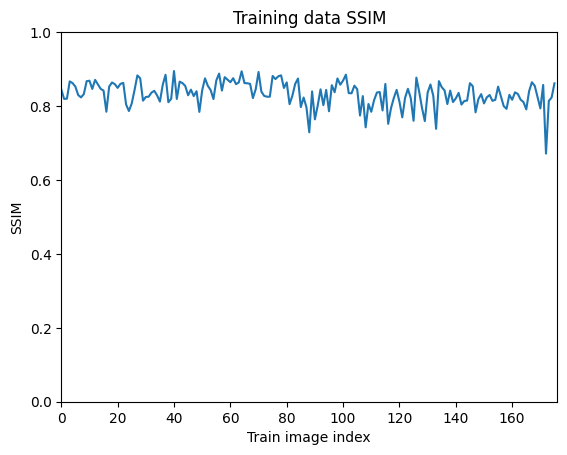

In [ ]:
plt.plot(ssim_scores)
plt.xlabel("Train image index")
plt.ylabel("SSIM")
plt.title("Training data SSIM")
plt.xlim(0, len(ssim_scores))
plt.ylim(0, 1)
plt.show()


#Calculate testing accuracy

In [ ]:
from PIL import Image

IMG_SIZE = 256

t1_dir = "/content/drive/MyDrive/finalT1T2Data/test_w_loc/T1"
t2_dir = "/content/drive/MyDrive/finalT1T2Data/test_w_loc/T2"
out_dir = "/content/drive/MyDrive/finalT1T2Data/testPredictions"   # where to save generated T2 images
os.makedirs(out_dir, exist_ok=True)

t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
t2_paths = sorted(glob(os.path.join(t2_dir, "*")))

def load_image_2d(path):
    img = Image.open(path).convert("L")                       # grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)

def denormalize(x):
    x = (x + 1.0) / 2.0         # [-1,1] → [0,1]
    x = (x * 255).clip(0, 255)
    return x.astype(np.uint8)

def compute_ssim(pred, target):
    pred_tf = tf.convert_to_tensor(pred, dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target, dtype=tf.float32)

    ssim_val = tf.image.ssim(pred_tf, target_tf, max_val=2.0)

    return float(ssim_val.numpy())

ssim_scores = []
for p_t1, p_t2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
    x = load_image_2d(p_t1)
    y_true = load_image_2d(p_t2)

    x_batch = x[None, ...]

    # Run generator
    y_pred = generator(x_batch, training=False).numpy()[0]

    # Compute SSIM
    ssim = compute_ssim(y_pred, y_true)
    ssim_scores.append(ssim)

    # Save prediction
    out_path = os.path.join(out_dir, os.path.basename(p_t1))
    Image.fromarray(((y_pred[...,0] + 1) * 127.5).astype(np.uint8)).save(out_path)

print("DONE! Predictions saved to:", out_dir)

print("Mean SSIM:", np.mean(ssim_scores))
print("Median SSIM:", np.median(ssim_scores))


100%|██████████| 46/46 [00:56<00:00,  1.22s/it]

DONE! Predictions saved to: /content/drive/MyDrive/finalT1T2Data/testPredictions
Mean SSIM: 0.6209136079186979
Median SSIM: 0.6205978393554688


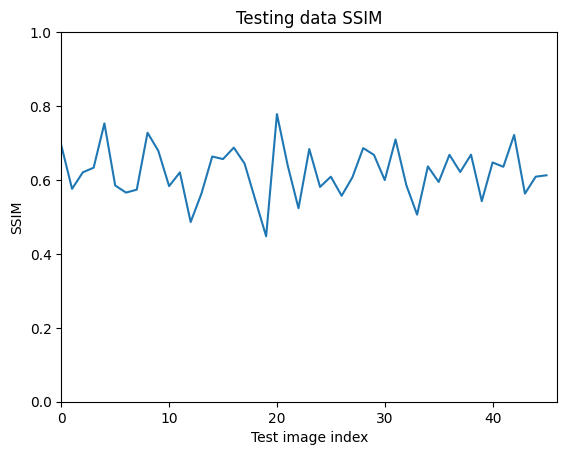

In [ ]:
plt.plot(ssim_scores)
plt.xlabel("Test image index")
plt.ylabel("SSIM")
plt.title("Testing data SSIM")
plt.xlim(0, len(ssim_scores))
plt.ylim(0, 1)
plt.show()

# Train ResNet18 to predict site

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

print(device)

cpu


In [ ]:
train_data_dir = "/content/drive/MyDrive/finalT1T2Data/trainPredictions"
test_data_dir = "/content/drive/MyDrive/finalT1T2Data/testPredictions"

In [ ]:
train_prediction_files = sorted([f for f in os.listdir(train_data_dir)])
hh_train_predictions_names = []
guys_train_predictions_names= []
for f in train_prediction_files:
  f_full_name = os.path.join(train_data_dir, f)
  if f_full_name.split('_')[1] == 'HH':
    hh_train_predictions_names.append(f_full_name)
  else:
    guys_train_predictions_names.append(f_full_name)

In [ ]:
test_prediction_files = sorted([f for f in os.listdir(test_data_dir)])
hh_test_predictions_names = []
guys_test_predictions_names= []
for f in test_prediction_files:
  f_full_name = os.path.join(test_data_dir, f)
  if f_full_name.split('_')[1] == 'HH':
    hh_test_predictions_names.append(f_full_name)
  else:
    guys_test_predictions_names.append(f_full_name)

In [ ]:
class scanSite(Dataset):
    def __init__(self, HH_files, guys_files):
        self.fpaths = HH_files + guys_files
        self.normalize = transforms.Normalize(mean=[0.449], std=[0.226])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('_')[1]=="HH" for fpath in self.fpaths] #HH=1, Guys=0
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
data = scanSite(hh_train_predictions_names, guys_train_predictions_names)

In [ ]:
data.__len__()

178

In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = scanSite(hh_train_predictions_names, guys_train_predictions_names)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = scanSite(hh_test_predictions_names, guys_test_predictions_names)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(20):

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

All losses and accuracies are for each epoch
 epoch 1/5, Training Loss: 0.6770654678344726, Training Accuracy: 0.61875, Validation Accuracy: 0.65625
 epoch 2/5, Training Loss: 0.5535478591918945, Training Accuracy: 0.69375, Validation Accuracy: 0.625
 epoch 3/5, Training Loss: 0.4491474449634552, Training Accuracy: 0.78125, Validation Accuracy: 0.71875
 epoch 4/5, Training Loss: 0.39662917852401736, Training Accuracy: 0.73125, Validation Accuracy: 0.59375
 epoch 5/5, Training Loss: 0.34283810257911684, Training Accuracy: 0.675, Validation Accuracy: 0.59375
 epoch 6/5, Training Loss: 0.3088650107383728, Training Accuracy: 0.74375, Validation Accuracy: 0.5
 epoch 7/5, Training Loss: 0.2900740683078766, Training Accuracy: 0.7375, Validation Accuracy: 0.53125
 epoch 8/5, Training Loss: 0.2228397399187088, Training Accuracy: 0.825, Validation Accuracy: 0.5
 epoch 9/5, Training Loss: 0.24715759754180908, Training Accuracy: 0.9125, Validation Accuracy: 0.59375
 epoch 10/5, Training Loss: 0.24

/tmp/ipython-input-3357252673.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


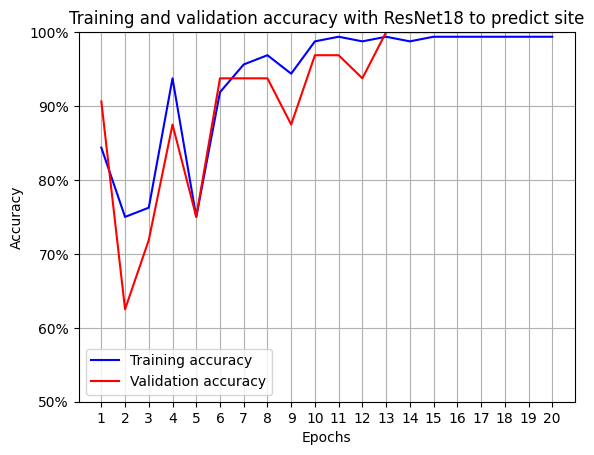

In [ ]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 to predict site')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

The model is able to predict which site each generated scan came from with 100% accuracy. Next step is to harmonize the input data and see if that decreases the site prediction accuracy.